In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.manifold import TSNE
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec as word2vec

/tmp/ipykernel_1086147/787023044.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1')


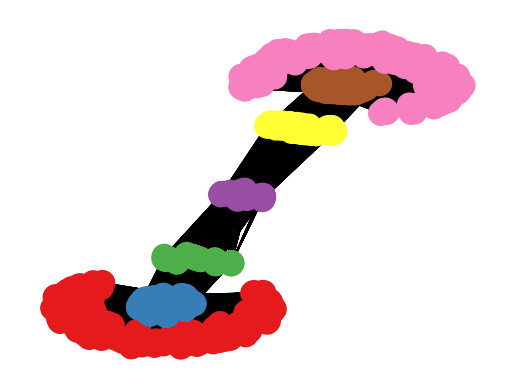

In [29]:
# 層の構造を定義
# L=3, M=2
# layer_sizes = [240, 120, 240]

# L=5, M=2
# layer_sizes = [184, 92, 48, 92, 184]

# L=7, M=2
layer_sizes = [164, 82, 41, 26, 41, 82, 164]

# L=3, M=5
# layer_sizes = [272, 56, 272]

# L=5, M=5
# layer_sizes = [245, 49, 12, 49, 245]

# L=7, M=5
# layer_sizes = [240, 48, 9, 6, 9, 48, 240]

# 色付けをする際の色を定義
cmap = plt.cm.get_cmap('Set1')

# グラフの作成
G = nx.Graph()
# 頂点の追加
for i, layer_size in enumerate(layer_sizes):
    color = cmap(i/len(layer_sizes))
    for j in range(layer_size):
        G.add_node(f'{i}-{j}', color=color, label=i)

# 辺の追加
for i, layer_size in enumerate(layer_sizes[:-1]):
    for j in range(layer_size):
        for k in range(layer_sizes[i + 1]):
            G.add_edge(f'{i}-{j}', f'{i+1}-{k}')

# グラフのポジションを設定
pos = nx.spring_layout(G)

# エッジリストへの変換
# edge_list = nx.to_edgelist(G)

# ノードに色をつけてプロットする
for i, layer_size in enumerate(layer_sizes):
    layer_nodes = [f"{i}-{j}" for j in range(layer_size)]
    node_colors = [G.nodes[node]['color'] for node in layer_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=layer_nodes, node_color=node_colors)
nx.draw_networkx_edges(G, pos)

# グラフを書き出し
nx.write_edgelist(G, "autoencoder_for_japanese_network.edgelist", data=False)
plt.axis('off')
plt.show()

In [30]:
#deepwalk ランダムサンプリングデータの生成
def make_random_walks(G, num_walk, length_of_walk):
    #ランダムウォークで歩いたノードを入れるlistを生成
    paths = list()
    #ランダムウォークを擬似的に行う
    for i in range(num_walk):
        node_list = list(G.nodes())
        for node in node_list:
            now_node = node
            #到達したノードを追加する用のリストを用意する
            path = list()
            path.append(str(now_node))
            for j in range(length_of_walk):
                #次に到達するノードを選択する
                next_node = random.choice(list(G.neighbors(now_node)))
                #リストに到達したノードをリストに追加する
                path.append(str(next_node))
                #今いるノードを「現在地」とする
                now_node = next_node
            #ランダムウォークしたノードをリストに追加
            paths.append(path)
        #訪れたノード群を返す
    return paths

In [31]:
# G = nx.read_edgelist('autoencoder_for_japanese_network.edgelist')

# Node2Vecを用いてグラフから点群データへ変換
# pが大きい -> DFS(深さ優先探索), qが大きい -> BFS(幅優先探索)
# node2vec = Node2Vec(G, dimensions=2, walk_length=1000, num_walks=10, p=1, q=0.5)
# model = node2vec.fit(window=10, min_count=0, batch_words=10)
nodes = list(G.nodes())
# node_embeddings = np.array([model.wv[node] for node in nodes])

# word2vecを用いてグラフから点群データへ変換
walking = make_random_walks(G, 1000, 10)
model = word2vec(walking, min_count = 0, vector_size = 2, window = 10, workers = 1)
node_embeddings = np.array([model.wv[node] for node in nodes])

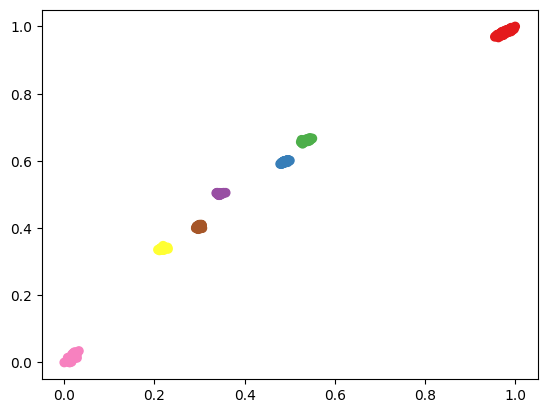

In [32]:
# 点群データの各点に変換前のノードの色を当てる(colorをラベルとして判定？)
colors = [nx.get_node_attributes(G, 'color')[node] for node in nodes]

# 正規化を行う
scaler = MinMaxScaler()
node_embeddings_normalized = scaler.fit_transform(node_embeddings)

# Plot the point cloud data with colors
plt.clf()
plt.scatter(node_embeddings_normalized[:, 0], node_embeddings_normalized[:, 1], c=colors)
plt.show()

In [33]:
# ノードのラベル情報を取得
labels = [G.nodes[node]['label'] for node in nodes]

# ラベル情報を含むデータフレームを作成
df = pd.DataFrame({'x': node_embeddings_normalized[:, 0], 'y': node_embeddings_normalized[:, 1], 'label': labels})

# csvに書き出し
df.to_csv('../data/autoencoder_600_7div_5ver.csv', index=False)

In [34]:
df

,x,y,label
0,0.963969,0.972242,0
1,0.978564,0.981098,0
2,1.000000,1.000000,0
3,0.984040,0.990881,0
4,0.987628,0.987581,0
...,...,...,...
595,0.007966,0.004694,6
596,0.007568,0.014098,6
597,0.025200,0.018782,6
598,0.022948,0.021543,6
